# Notebook voor het omzetten van de met Wageningenmodellen en overstortschatter berekende afvoeren naar lateralen D_HYDRO.

## Goal of this script
To read, transform and save discharge data from various sources, into a format that can be used by D-HYDRO software. The user must be able to specify the begin and end date of the queried dataseries, and the scenario that they desire (historical data, ghg90, etc.). 

## Preparation

### Import the required modules

In [6]:
import os
from os.path import splitext, join, basename
import glob
import pandas as pd
import geopandas as gpd
import re
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
from IPython.core.interactiveshell import InteractiveShell
from lxml import etree
import pandas as pd
InteractiveShell.ast_node_interactivity = "all"

### Set relative paths to input data

In [7]:
# Absolute path of the script, which will serve as a base to obtain relative paths to all other used files.
path_script = os.path.abspath('')
path_data = join(os.path.dirname(path_script), r'00_Data')

# Shapefiles
laterals_shp_path = join(path_data, r'input_afvoeren\shapefiles\laterals.shp')
wagmod_shp_path = join(path_data, r'input_afvoeren\shapefiles\NAvakken.shp')

overstorten_shp_path = join(path_data, r'input_afvoeren\\shapefiles\lozingspunten.shp')
modelarea_shp_path = join(path_data, r'input_afvoeren\shapefiles\HoogeRaam.shp')

# Timeseries
laterals_data_path = join(path_data, r'input_afvoeren\timeseries\landelijk')

overstorten_data_path = join(path_data, r'input_afvoeren\timeseries\overstorten')

### Configure settings

In [8]:
INTEGRITY = True # If true, checks if indexes of dataframes are unique.
SAVE_INTERMEDIATE_RESULTS = True # If true, saves outputs of scenarios to .csv files to check validity.
SCENARIO = 'hist' # pick one scenario ('hist', 'ghg120', etc.)



### Read the shapefiles 
- The locations of the laterals to which the discharge must finally be coupled
- The location of the overstorten
- The polygons that are used by the Wageningen Model, to know which discharge to couple with which laterals

In [9]:
gdf_modelarea = gpd.read_file(modelarea_shp_path)

gdf_laterals = (
    gpd.read_file(laterals_shp_path)
    .set_index('CODE', verify_integrity = True)
    [['Opp_hactar','X','Y','geometry']]
)
gdf_laterals['type'] = 'laterals'
gdf_laterals = gdf_laterals[gdf_laterals.within(gdf_modelarea.at[0,'geometry'])]

gdf_wagmod = (
    gpd.read_file(wagmod_shp_path)
    [['GAFIDEN','geometry']]
)



gdf_overstorten = gpd.read_file(overstorten_shp_path).set_index('RIODAT_ZRO', 
    verify_integrity=False 
    )[['geometry']]
gdf_overstorten['type'] = 'overstort'
gdf_overstorten = gdf_overstorten[gdf_overstorten.within(gdf_modelarea.at[0,'geometry'])]

gdf_laterals.head()
gdf_wagmod.head()
gdf_overstorten.head()


c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\geopandas\array.py:166: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data), crs=crs)
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\geopandas\array.py:166: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.from_shapely(data), crs=crs)


,Opp_hactar,X,Y,geometry,type
CODE,,,,,
1057660L,10.810582,178684.0,415329.0,POINT (178683.501 415329.122),laterals
1055340L,7.907117,174751.0,414165.0,POINT (174751.363 414165.441),laterals
1055935L,19.906791,175822.0,414635.0,POINT (175821.510 414634.836),laterals
1056150L,23.648218,178940.0,416196.0,POINT (178940.195 416196.045),laterals
1057380L,3.253255,177919.0,415169.0,POINT (177919.206 415169.070),laterals


,GAFIDEN,geometry
0,107a,"POLYGON ((181239.885 413496.624, 181356.345 41..."
1,112,"POLYGON ((198494.918 404086.773, 198514.509 40..."
2,112,"POLYGON ((197040.942 402079.256, 196964.548 40..."
3,108a,"POLYGON ((187679.170 408065.972, 188475.450 40..."
4,114a,"POLYGON ((195514.316 404681.126, 195318.198 40..."


,geometry,type
RIODAT_ZRO,,
MIL-LAN-ESP-12,POINT (179008.572 412581.488),overstort
LAN-ZEE-STE-14,POINT (175266.816 411519.820),overstort
LAN-ZEE-MEL-12,POINT (175290.515 412483.900),overstort
MIL-LAN-KER-11,POINT (178754.737 413301.168),overstort
LAN-ZEE-OVE-15,POINT (175337.615 410061.422),overstort


### Combine the tables of the laterals and the overstorten and save this shapefile. 
One output of the script is to create a shapefile with all the locations to which model data must be coupled, which is hereby done.

In [10]:
# Create the shapefile containing all locations (laterals and overstorten). This is a component of the final output.
lateral_locations = pd.concat([gdf_laterals,gdf_overstorten], 
    verify_integrity=False 
    )[['geometry','type']]
lateral_locations['globalid'] = lateral_locations.index
lateral_locations.to_file(join(path_data, r'output_afvoeren\shapefiles\lateralen_locations'))
    

c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\geopandas\io\file.py:234: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


The Wageningen Model Polygons contain values for GAFIDEN, which is an identifier used to obtain Specifieke Afvoer. Most laterals intersect a polygon, but for the 108 that do not, the join is made based on nearest polygon; a column is added containing the distance from the lateral to the nearest polygon. A new dataframe (gdf_unexactmatches) is created that contains laterals that are more than zero away from a polygon, just to easily see which ones aren't matched directly.

Unfortunately, the current delft3dfmpy environment (2.0.3) uses a fairly outdated version of geopandas. Therefore, rather than the geodataframe.sjoin_nearest() function, I am forced to use a for loop with a runtime of 30-40 seconds. This can be changed when the environment updates geopandas to a more recent version.

In [11]:
polygons=gpd.GeoDataFrame(gdf_wagmod.geometry)
gdf_laterals_joined = gdf_laterals

for point in gdf_laterals_joined.geometry.index:
    nearest_polygon = polygons.distance(gdf_laterals_joined.geometry[point]).sort_values().index[0]
    gdf_laterals_joined.loc[point, 'GAFIDEN'] = gdf_wagmod.loc[nearest_polygon,'GAFIDEN']

    distance = polygons.distance(gdf_laterals_joined.geometry[point]).min()
    gdf_laterals_joined.loc[point, 'afstand'] = distance
    
gdf_laterals_joined.head()
gdf_unexactmatches = gdf_laterals_joined[gdf_laterals_joined['afstand']>0]

,Opp_hactar,X,Y,geometry,type,GAFIDEN,afstand
CODE,,,,,,,
1057660L,10.810582,178684.0,415329.0,POINT (178683.501 415329.122),laterals,105,0.0
1055340L,7.907117,174751.0,414165.0,POINT (174751.363 414165.441),laterals,105,0.0
1055935L,19.906791,175822.0,414635.0,POINT (175821.510 414634.836),laterals,105,0.0
1056150L,23.648218,178940.0,416196.0,POINT (178940.195 416196.045),laterals,105,0.0
1057380L,3.253255,177919.0,415169.0,POINT (177919.206 415169.070),laterals,105,0.0


### Plot the different shapes to create an idea of what we are dealing with. 

I plotted the laterals to give an idea of what we're working with.

(170000.0, 200000.0)

(390000.0, 420000.0)

(171000.0, 180000.0)

(408000.0, 417000.0)

c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
c:\Users\langjo02\.conda\envs\delft3dfmpy_2.0.3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<AxesSubplot:>

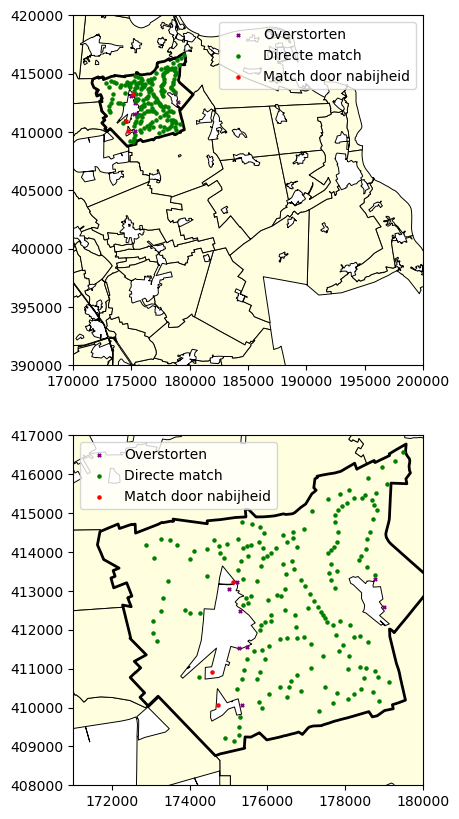

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
ax1.set_xlim(170000, 200000)
ax1.set_ylim(390000, 420000)
ax2.set_xlim(171000, 180000)
ax2.set_ylim(408000, 417000)

for plot in (ax1, ax2):
    
    fig=gdf_wagmod.plot(ax=plot, fc="lightyellow", edgecolor='black', lw=0.7)
    fig = gdf_modelarea.plot(ax=plot, fc='none', edgecolor='black', lw=2)
    fig=gdf_overstorten.plot(ax=plot, color = 'purple', marker='x',markersize = 5, label='Overstorten')
    fig=gdf_laterals_joined[gdf_laterals_joined['afstand']==0].plot(ax=plot, color='green', label = 'Directe match', markersize = 5)
    fig=gdf_laterals_joined[gdf_laterals_joined['afstand']>0].plot(ax=plot, color='red', label = 'Match door nabijheid', markersize = 5)
    plot.legend()
fig


## Extract, Transform and Load data

### Landelijke afvoer

In [13]:
inputfolder = join(path_data,r'input_afvoeren/timeseries/landelijk/')

wagmodFiles = os.listdir(join(inputfolder, SCENARIO))

## Read Wageningen model output (discharges) per region, and multiply by the area belonging to each lateral
ls_wagmodoutput = []

for region in wagmodFiles:
    
    metadata_region = pd.read_csv(join(inputfolder, SCENARIO, region), nrows=1, skiprows=[0,2], header=None)[0][0]
    model = re.search('model:(.*) (?:van|met winterbui)', metadata_region).group(1)
            
    df_region = pd.read_csv(
            join(inputfolder, SCENARIO, region), 
            header=4, 
            delim_whitespace=True, 
            usecols=['-I-','-QC-'],
            )

    df_region=df_region.set_index(
            pd.to_datetime(df_region['-I-'],
            origin=pd.Timestamp('2010-11-08 23:00:00'),
            unit='h')
        ).drop(labels=['-I-'], axis='columns').rename(columns={'-QC-':model})
    
    ls_wagmodoutput.append(df_region)

# The result is a list containing dataframes as items
ls_wagmodoutput, len(ls_wagmodoutput)

# Combine the dataframes into one big dataframe
df_wagmodoutput = pd.concat(ls_wagmodoutput, axis=1, verify_integrity=True).T * 10 / 3600

# Set the index to be only the 'GAFIDEN'
for i in range(len(df_wagmodoutput.index)):
    ID = df_wagmodoutput.index[i].split(' ')[0]
    df_wagmodoutput.loc[df_wagmodoutput.index[i],'GAFIDEN'] = ID

### Multiplication
gdf_laterals_joined['Latid'] = gdf_laterals_joined.index
output_laterals = gdf_laterals_joined.merge(df_wagmodoutput, on='GAFIDEN', how='left')
output_laterals.set_index('Latid', inplace=True)
output_landelijkeafvoer = output_laterals.iloc[:,7:].multiply(output_laterals['Opp_hactar'],axis='index').T
output_landelijkeafvoer.index = pd.to_datetime(output_landelijkeafvoer.index)

if SAVE_INTERMEDIATE_RESULTS == True:
    output_landelijkeafvoer.to_csv(join(path_data, r'output_afvoeren\timeseries\landelijk', SCENARIO + '.csv'), sep = ';')

([                         105
  -I-                         
  2010-11-09 00:00:00  0.02494
  2010-11-09 01:00:00  0.02489
  2010-11-09 02:00:00  0.02485
  2010-11-09 03:00:00  0.02481
  2010-11-09 04:00:00  0.02477
  ...                      ...
  2023-11-08 19:00:00  0.00000
  2023-11-08 20:00:00  0.00000
  2023-11-08 21:00:00  0.00000
  2023-11-08 22:00:00  0.00000
  2023-11-08 23:00:00 -0.05224
  
  [113952 rows x 1 columns],
                           106
  -I-                         
  2010-11-09 00:00:00  0.02099
  2010-11-09 01:00:00  0.02098
  2010-11-09 02:00:00  0.02097
  2010-11-09 03:00:00  0.02096
  2010-11-09 04:00:00  0.02095
  ...                      ...
  2023-11-08 19:00:00  0.00196
  2023-11-08 20:00:00  0.00247
  2023-11-08 21:00:00  0.00295
  2023-11-08 22:00:00  0.00340
  2023-11-08 23:00:00  0.00383
  
  [113952 rows x 1 columns],
                          107a
  -I-                         
  2010-11-09 00:00:00  0.02911
  2010-11-09 01:00:00  0.02919
  2010

### Overstorten

#### Historic data

##### Define functions
Reading XML files can be a hassle and it doesn't improve the readability of the code. Therefore I wrapped it into a function that takes the path of an xml file and produces a list that contains a dataframe for each.

In [14]:
def parse_xml(path_xml):
    """XML files consist of a root node that can have numerous generation of childnodes. This function takes the path to an xml from a certain year and 
    returns a list of first generation nodes, which I called series (same as in the xml files). Each Serie belongs to a specific overstort, and contain the second generation of childnodes: 
    - one Header (metadata) 
    - many Events (the actual data).
    The function returns a list of which each item is a serie, which in turn contains data and metadata for one overstort each.
    """
    # Read the xml file and extract the tree and root. Then filter to get the series branch.
    tree = etree.parse(path_xml)
    root = tree.getroot()
    list_of_series = [child for child in root.getchildren() if 'series' in child.tag]

    return list_of_series

def series_to_dataframe(serie):
    """Takes an individual Serie output by the function "parse_xml", transforms the data and metadata, 
    creates a clear dataframe.
    """
    # Extract the ID from the metadata. Used as column header in output.
    header = serie.find('{http://www.wldelft.nl/fews/PI}header')
    id = header.find('{http://www.wldelft.nl/fews/PI}stationName').text
    
    # Extract the actual data and reformat into a dataframe wtih a datetime index. 
    events = serie.findall('{http://www.wldelft.nl/fews/PI}event')
    data = pd.DataFrame([i.values() for i in events])
    index = pd.DatetimeIndex(pd.to_datetime(data[0]+' '+data[1], format="%Y-%m-%d %H:%M:%S"))
    data_indexed = pd.DataFrame({id: data[2].values}, index=index)
    data_divided = pd.to_numeric(data_indexed[id]).div(3600)
    
    return data_divided

##### Loop over all xml files and generate output

In [15]:
if SCENARIO == 'hist':
    path_input_overstorten_hist = join(path_data,r'input_afvoeren\timeseries\overstorten\hist')
    input_files = glob.glob(path_input_overstorten_hist + '/*.xml')
    data_hist_ls = []

    # I suggest to view one of the input xml files with this code, to understand the tree and its branches.
    for path_xml in input_files:
        
        ls_data_year = []
        list_of_series = parse_xml(path_xml)

        for serie in list_of_series:
            dataframe = series_to_dataframe(serie)
            ls_data_year.append(dataframe)

        # Combine outputs series vertically, merging on the datetime index. Then add the output of this year to the list of outputs from all years.
        df_data_year = pd.concat(ls_data_year,axis='columns',verify_integrity=True)
        data_hist_ls.append(df_data_year)

    # Combine outputs from different years horizontally
    output_overstorten_hist = pd.concat(data_hist_ls,axis='index',verify_integrity=True)
    output_overstorten = output_overstorten_hist.fillna(0)
    output_overstorten

    if SAVE_INTERMEDIATE_RESULTS == True:
        output_overstorten.to_csv(join(path_data, r'output_afvoeren\timeseries\overstorten', 'hist.csv'), sep = ';')
        
elif 'ghg' in SCENARIO:
    path_input_overstorten_blokbuien = join(path_data,r'input_afvoeren\timeseries\overstorten\blokbuien')
    input_files = glob.glob(path_input_overstorten_blokbuien + '/*.xlsx')

    for file in input_files:
        excel_table = pd.read_excel(file, skiprows=3)
        index_col = excel_table['code OS']
        data = excel_table.filter(regex='Unnamed', axis='columns').div(3600) # The columns containing the data are prefixed by 'Unnamed' due to Excel structure. 
        data.columns = range(1,76)
        data.index = index_col
        data_transposed = data.T

        output_overstorten = data_transposed
        output_overstorten

        if SAVE_INTERMEDIATE_RESULTS == True:
            output_overstorten.to_csv(join(path_data, r'output_afvoeren\timeseries\overstorten', basename(splitext(file)[0])+ '.csv'), sep = ';')
else:
    print('No valid scenario given as input.')

,AST-AST-CAM-15,AST-AST-HOO-8,AST-AST-IND-13,AST-AST-IND-24,AST-AST-IND-25,AST-AST-IND-26,AST-AST-IND-27,AST-AST-KOM-1,AST-AST-KOM-2,AST-AST-KOM-3,...,VEG-VEG-WES-28,VEG-VEG-WES-30,VEG-VEG-ZUI-15,VEG-VEG-ZUI-16,VEG-VEG-ZUI-17,VEG-ZIJ-KER-52,VEG-ZIJ-RUD-53,GEM-BAK-SPE-27,LAN-SCH-LOU-3,HEL-STI-KER-66
2010-01-02 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-02 20:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-02 23:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-03 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-30 22:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Combine data into final output

In [16]:
output_landelijkeafvoer

Latid,1057660L,1055340L,1055935L,1056150L,1057380L,1057400L,1050020L,1050120L,1050545L,1051250L,...,1051710L,1051680L,1051690L,1051700L,1050210L,1050540L,1051610L,1055940L,1053530L,1054260L
2010-11-09 00:00:00,0.000749,0.000548,0.001379,0.001638,0.000225,0.000178,0.000843,0.007369,0.000695,0.000966,...,0.000810,0.000135,0.000464,0.000376,0.000135,0.000564,0.005017,0.000143,0.000314,0.000555
2010-11-09 01:00:00,0.000747,0.000547,0.001376,0.001635,0.000225,0.000178,0.000841,0.007354,0.000694,0.000964,...,0.000809,0.000135,0.000463,0.000375,0.000135,0.000563,0.005007,0.000143,0.000313,0.000553
2010-11-09 02:00:00,0.000746,0.000546,0.001374,0.001632,0.000225,0.000178,0.000840,0.007342,0.000693,0.000963,...,0.000807,0.000135,0.000462,0.000375,0.000135,0.000562,0.004999,0.000142,0.000313,0.000553
2010-11-09 03:00:00,0.000745,0.000545,0.001372,0.001630,0.000224,0.000178,0.000839,0.007330,0.000691,0.000961,...,0.000806,0.000135,0.000461,0.000374,0.000135,0.000561,0.004991,0.000142,0.000312,0.000552
2010-11-09 04:00:00,0.000744,0.000544,0.001370,0.001627,0.000224,0.000177,0.000837,0.007318,0.000690,0.000960,...,0.000805,0.000134,0.000460,0.000374,0.000135,0.000560,0.004983,0.000142,0.000312,0.000551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-08 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-08 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-08 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
output_combined = pd.concat([output_landelijkeafvoer, output_overstorten], keys=['Defined Lateral Disc', 'Lateral disch.(m3/s)'], axis=1)
output_combined = output_combined[pd.to_datetime("2010-11-08 23:00:00", format='%Y-%m-%d %H:%M:%S'):pd.to_datetime("2010-11-21 23:00:00", format='%Y-%m-%d %H:%M:%S')]
output_final = output_combined.fillna(0)
#index = ((pd.to_datetime(output_final.index)- pd.to_datetime('2010-11-09 00:00:00', format='%Y-%m-%d'))/pd.Timedelta(minutes=1)).astype(int)
#output_final.set_index(index,inplace=True)
output_final.to_csv(join(path_data, r'output_afvoeren\timeseries', 'combinedoutput.csv'), sep = ';')